# Problèmes

### 1)
Primal: $\underset{x \in \mathbb{R}^3}{\min} \frac{1}{2} x' Q x + c' x ~~~~~~~~ s.t. ~ A x = b ~, ~~ x \ge 0$

with  $Q = \begin{bmatrix} 6 & 2 & 1\\ 2 & 5 & 2\\ 1 & 2 & 4 \end{bmatrix} $, $c = \begin{bmatrix} -8 \\ -3 \\ -3 \end{bmatrix}$, $A = \begin{bmatrix} 1 & 0 &1 \\ 0 & 1 & 1 \end{bmatrix}$ , and $b = \begin{bmatrix} 3 \\ 0 \end{bmatrix} $.


### 2) 
AFIRO        28 rows    32 cols        88 nonzeros       794 bytes      -4.6475314286E+02 optimalvalue

In [1]:
using LinearAlgebra
using LaTeXStrings
using DataFrames
using DataStructures
using QuadraticModels
using Printf
using SparseArrays
using BenchmarkTools
using NLPModels
using LinearOperators
using QPSReader
using SolverTools
using SolverBenchmark
using LDLFactorizations

# Mehrotra formulation plus générale:

min $c_0 + c'x + \frac{1}{2} x'Hx ~~~~$ s.t. $ Ax = b $ and $l \le x \le u$ 

In [2]:
function display_results(result)
    # fonction pour l'affichage
    println("\n-----------------------------------------------------------------------")
    println("------------------------------- RESULTS -------------------------------")
    result
end

function init_x0(lvar, uvar)
    # choice of an init point x0
    x0 = zeros(length(lvar))
    for i=1:length(x0)
        if lvar[i] == -Inf && uvar[i] == Inf
            x0[i] = 0.
        elseif lvar[i] == -Inf && uvar[i] != Inf
            x0[i] = uvar[i] - 1.
        elseif lvar[i] != -Inf && uvar[i] == Inf
            x0[i] = lvar[i] + 1.
        else
            x0[i] = (lvar[i] + uvar[i]) / 2 
        end
    end  
    return x0
end

function init_x0_lsq(A, b, lvar, uvar)
    x_tilde = A\b
    n = length(x_tilde)
    for i=1:n
        if x_tilde[i] <= lvar[i]
            x_tilde[i] = lvar[i] + 1.
        elseif uvar[i] <= x_tilde[i]
            x_tilde[i] = uvar[i] - 1.
        end
        if !(lvar[i] < x_tilde[i] < uvar[i])
            x_tilde[i] = (lvar[i] + uvar[i]) / 2.
        end
    end

    return x_tilde
end

function starting_points(Q, A, b, c, lvar, uvar, ilow, iupp, irng, J_augm, ρ, n_rows, n_cols)

    tmp_diag = vcat(-ρ*ones(n_cols),spzeros(n_rows))

    J_fact = ldlt(Symmetric(J_augm-Diagonal(tmp_diag), :U))
    init_xλ = J_fact \ [c ; b ]
    x0 = init_xλ[1:n_cols]
    λ0 = init_xλ[n_cols+1:end]
    s0_l, s0_u = zeros(n_cols), zeros(n_cols)
    dual_val = Q*x0 - A'*λ0 + c
    s0_l[ilow] = dual_val[ilow]
    s0_u[iupp] = -dual_val[iupp]

    x0_l1, x0_u1 = x0[ilow], x0[iupp]
    if length(ilow) == 0
        δx_l1, δs_l1 = 0., 0.
    else
        δx_l1 = max(-1.5*minimum(x0_l1 - lvar[ilow]), 0.)
        δs_l1 = max(-1.5*minimum(s0_l[ilow]), 0.)
    end

    if length(iupp) == 0
        δx_u1, δs_u1 = 0., 0.
    else
        δx_u1 = max(-1.5*minimum((uvar[iupp] - x0_u1)), 0.)
        δs_u1 = max(-1.5*minimum(s0_u[iupp]), 0.)
    end
    
    x0_l1 .+= δx_l1
    x0_u1 .-= δx_u1
    s0_l1 = s0_l[ilow] .+ δs_l1
    s0_u1 = s0_u[iupp] .+ δs_u1
    xs_l1, xs_u1 = s0_l1'*(x0_l1 - lvar[ilow]), s0_u1'*(uvar[iupp] - x0_u1)
    if length(ilow) == 0
        δx_l2, δs_l2 = 0., 0.
    else
        δx_l2 = δx_l1 + 0.5 *  xs_l1 / sum(s0_l1)
        δs_l2 = δs_l1 + 0.5 * xs_l1 / sum(x0_l1-lvar[ilow])
    end
    if length(iupp) == 0
        δx_u2, δs_u2 = 0., 0.
    else
        δx_u2 = δx_u1 + 0.5 *  xs_u1 / sum(s0_u1)
        δs_u2 = δs_u1 + 0.5 * xs_u1 / sum(uvar[iupp]-x0_u1)
    end
    println(δx_l1)
    x0[ilow] .+= δx_l2 
    x0[iupp] .-= δx_u2
    s0_l[ilow] = s0_l[ilow] .+ max(δs_l2, δs_u2)
    s0_u[iupp] = s0_u[iupp] .+ max(δs_l2, δs_u2)

    for i in irng
        if (lvar[i] < x0[i] < uvar[i]) == false
            x0[i] = (lvar[i] + uvar[i]) / 2.
        end
    end

    @assert all(x0 .> lvar) && all(x0 .< uvar)
    @assert all(s0_l[ilow] .> 0) && all(s0_u[iupp] .> 0)

    return x0, λ0, s0_l, s0_u
end



function starting_points2(Q, A, b, c, lvar, uvar, ilow, iupp, irng, J_augm, ρ, n_rows, n_cols)

    tmp_diag = vcat(-ones(n_cols),spzeros(n_rows))

    J_fact = ldlt(Symmetric(J_augm-Diagonal(tmp_diag), :U))
    init_xλ = J_fact \ [zeros(n_cols) ; b ]
    x0 = init_xλ[1:n_cols]
    λ0 = init_xλ[n_cols+1:end]
    s0_l, s0_u = zeros(n_cols), zeros(n_cols)
    dual_val = Q*x0 - A'*λ0 + c
    s0_l[ilow] = dual_val[ilow]
    s0_u[iupp] = -dual_val[iupp]

    x0_l1, x0_u1 = x0[ilow], x0[iupp]

    for i in ilow
        δx_l = max(-1.5*(x0[i] - lvar[i]), 1.)
        δs_l = max(-1.5*s0_l[i], 1e-6)
        x0[i] += δx_l 
        s0_l[i] += δs_l 
    end

    for i in iupp
        δx_u = max(-1.5*(uvar[i] - x0[i]), 1.)
        δs_u = max(-1.5*s0_u[i], 1.e-6)
        x0[i] -= δx_u 
        s0_u[i] += δs_u 
    end

    for i in irng
        if (lvar[i] < x0[i] < uvar[i]) == false
            x0[i] = (lvar[i] + uvar[i]) / 2.
        end
    end

    @assert all(x0 .> lvar) && all(x0 .< uvar)
    @assert all(s0_l[ilow] .> 0) && all(s0_u[iupp] .> 0)

    return x0, λ0, s0_l, s0_u
end


function starting_points3(Q, A, b, c, lvar, uvar, ilow, iupp, irng, J_augm, ρ, n_rows, n_cols)

    tmp_diag = vcat(ρ*ones(n_cols),spzeros(n_rows))

    #J_fact = ldlt(Symmetric(J_augm-Diagonal(tmp_diag), :U))
    J_fact = ldl(Symmetric(J_augm-Diagonal(tmp_diag), :U))
    J_P = J_fact.P
    init_xλ = J_fact \ [zeros(n_cols) ; b]
    #init_xλ2 = J_fact \ [c ; zeros(n_rows)]
    x0 = init_xλ[1:n_cols]
    λ0 = init_xλ[n_cols+1:end]
    s0_l, s0_u = zeros(n_cols), zeros(n_cols)
    dual_val = Q*x0 - A'*λ0 + c
    s0_l[ilow] = @views dual_val[ilow]
    s0_u[iupp] = @views -dual_val[iupp]

    x0_l1, x0_u1 = x0[ilow], x0[iupp]
    if length(ilow) == 0
        δx_l1, δs_l1 = 0., 0.
    else
        δx_l1 = @views max(-1.5*minimum(x0_l1 - lvar[ilow]), 1.)
        δs_l1 = @views max(-1.5*minimum(s0_l[ilow]), 1.e-4)
    end
    
    if length(iupp) == 0
        δx_u1, δs_u1 = 0., 0.
    else
        δx_u1 = @views max(-1.5*minimum((uvar[iupp] - x0_u1)), 1.)
        δs_u1 = @views max(-1.5*minimum(s0_u[iupp]), 1.e-4)
    end
    
    x0_l1 .+= δx_l1
    x0_u1 .-= δx_u1
    s0_l1 = @views s0_l[ilow] .+ δs_l1
    s0_u1 = @views s0_u[iupp] .+ δs_u1
    xs_l1, xs_u1 = @views s0_l1'*(x0_l1 - lvar[ilow]), s0_u1'*(uvar[iupp] - x0_u1)
    if length(ilow) == 0
        δx_l2, δs_l2 = 0., 0.
    else
        δx_l2 = δx_l1 + 0.5 *  xs_l1 / sum(s0_l1)
        δs_l2 = @views δs_l1 + 0.5 * xs_l1 / sum(x0_l1-lvar[ilow])
    end
    if length(iupp) == 0
        δx_u2, δs_u2 = 0., 0.
    else
        δx_u2 = δx_u1 + 0.5 *  xs_u1 / sum(s0_u1)
        δs_u2 = @views δs_u1 + 0.5 * xs_u1 / sum(uvar[iupp]-x0_u1)
    end
    δx = max(δx_l2, δx_u2)
    δs = max(δs_l2, δs_u2)
    x0[ilow] .+= δx
    x0[iupp] .-= δx
    s0_l[ilow] = @views s0_l[ilow] .+ δs
    s0_u[iupp] = @views s0_u[iupp] .+ δs

    for i in irng
        if (lvar[i] < x0[i] < uvar[i]) == false
            x0[i] = (lvar[i] + uvar[i]) / 2.
        end
    end

    @assert all(x0 .> lvar) && all(x0 .< uvar)
    @assert @views all(s0_l[ilow] .> 0) && all(s0_u[iupp] .> 0)

    return x0, λ0, s0_l, s0_u, J_P
end

function starting_points4(Q, A, b, c, lvar, uvar, ilow, iupp, irng, J_augm, ρ, n_rows, n_cols)

    x0 = A\b
    
    if length(ilow) == 0
        δx_l1 = 0.
    else
        δx_l1 = max(-2.5*minimum(x0[ilow] - lvar[ilow]), 1.)
    end

    if length(iupp) == 0
        δx_u1 = 0.
    else
        δx_u1 = max(-2.5*minimum((uvar[iupp] - x0[iupp])), 1.)
    end
    
    x0[ilow] .+= δx_l1
    x0[iupp] .-= δx_u1
    
    for i in irng
        if (lvar[i] < x0[i] < uvar[i]) == false
            x0[i] = (lvar[i] + uvar[i]) / 2.
        end
    end
    
    @assert all(x0 .> lvar) && all(x0 .< uvar)
    λ0 = sparse(A') \ (c+Q*x0)
    dual_val = Q*x0 - A'*λ0 + c
    s0_l, s0_u = zeros(n_cols), zeros(n_cols)
    s0_l[ilow] = dual_val[ilow]
    s0_u[iupp] = dual_val[iupp]
    
    s0_l[ilow] .= 1.
    s0_u[iupp] .= 1.    
    @assert all(s0_l[ilow] .> 0) && all(s0_u[iupp] .> 0)

    return x0, λ0, s0_l, s0_u
end

starting_points4 (generic function with 1 method)

In [3]:
function compute_α_dual(v, dir_v)
    n = length(v)
    if n == 0
        return 1.
    end
    α = 1.
    for i=1:n
        if dir_v[i] < 0.
            α_new = -v[i] * 0.995 / dir_v[i]
            if α_new < α
                α = α_new
            end
        end
    end
    return α
end


    
function compute_α_primal(v, dir_v, lvar, uvar)
    n = length(v)
    α_l, α_u = 1., 1.
    for i=1:n
        if dir_v[i] > 0.
            α_u_new = (uvar[i] - v[i]) * 0.995 / dir_v[i]
            if α_u_new < α_u
                α_u = α_u_new
            end
        elseif dir_v[i] < 0.
            α_l_new = (lvar[i] - v[i]) * 0.995 / dir_v[i]
            if α_l_new < α_l
                α_l = α_l_new
            end
        end
    end
    return min(α_l, α_u)
end



function compute_μ(x_minus_lvar, uvar_minus_x, s_l, s_u, nb_low, nb_upp)
    return (s_l' * x_minus_lvar + s_u' * uvar_minus_x) / (nb_low + nb_upp)
end


function is_in_Neighborhood_inf(gamma, x_l, x_u, s_l, s_u, lvar, uvar)
    # check if the current point is in N_inf(gamma)
    # true : (xi_l - lvari) * si_l >= gamma mu   and   (uvari - xi_u) * si_u >= gamma mu 
    mu = Compute_mu(x_l, x_u, s_l, s_u, lvar, uvar)
    for i=1:length(x_l)
        if (x_l[i] - lvar[i]) * s_l[i] < gamma*mu
            return false
        end
    end
    for i=1:length(x_u)
        if (uvar[i] - x_u[i]) * s_u[i] < gamma*mu
            return false
        end
    end
    return true
end

is_in_Neighborhood_inf (generic function with 1 method)

In [4]:
function solve_augmented_system_aff!(J_fact, Δ_aff, Δ_x_λ, rc, rb, x_minus_lvar, uvar_minus_x, 
                                     s_l, s_u, ilow, iupp,  n_cols, n_rows, n_low)
    
    F_x_λ_aff = [-rc 
                 -rb]
    F_x_λ_aff[ilow] += @views s_l[ilow]
    F_x_λ_aff[iupp] -= @views s_u[iupp]
    
    Δ_x_λ = ldiv!(Δ_x_λ , J_fact, F_x_λ_aff)
#     Δ_aff = @views [Δ_x_λ
#                     -s_l[ilow] - s_l[ilow].*Δ_x_λ[1:n_cols][ilow]./x_minus_lvar
#                     -s_u[iupp] + s_u[iupp].*Δ_x_λ[1:n_cols][iupp]./uvar_minus_x]
    Δ_aff[1:n_cols+n_rows] = Δ_x_λ
    Δ_aff[n_cols+n_rows+1:n_cols+n_rows+n_low] = @views -s_l[ilow] - s_l[ilow].*Δ_x_λ[1:n_cols][ilow]./x_minus_lvar
    Δ_aff[n_cols+n_rows+n_low+1:end] = @views -s_u[iupp] + s_u[iupp].*Δ_x_λ[1:n_cols][iupp]./uvar_minus_x
    return Δ_aff
end

function solve_augmented_system_cc!(J_fact, Δ_cc, Δ_x_λ ,Δ_aff, σ, μ,x_minus_lvar, uvar_minus_x, 
                                    s_l, s_u, ilow, iupp, n_cols, n_rows, n_low)


    rxs_l = @views -σ*μ .+ Δ_aff[1:n_cols][ilow].*Δ_aff[n_rows+n_cols+1: n_rows+n_cols+n_low]
    rxs_u = @views σ*μ .+ Δ_aff[1:n_cols][iupp].*Δ_aff[n_rows+n_cols+n_low+1: end]

    F_x_λ_cc = zeros(n_cols+n_rows)
    F_x_λ_cc[ilow] += rxs_l./x_minus_lvar
    F_x_λ_cc[iupp] += rxs_u./uvar_minus_x

#     F_x_λ_cc = [ I_low*inv_X_L*rxs_l + I_op_upp*inv_X_U*rxs_u
#                                    Or                 ]
    
    Δ_x_λ = ldiv!(Δ_x_λ , J_fact, F_x_λ_cc)

#     Δ_cc = @views [Δ_x_λ
#                    -(rxs_l+s_l[ilow].*Δ_x_λ[1:n_cols][ilow])./x_minus_lvar
#                    (rxs_u+s_u[iupp].*Δ_x_λ[1:n_cols][iupp])./uvar_minus_x ]
    Δ_cc[1:n_cols+n_rows] = Δ_x_λ
    Δ_cc[n_cols+n_rows+1:n_cols+n_rows+n_low] = @views -(rxs_l+s_l[ilow].*Δ_x_λ[1:n_cols][ilow])./x_minus_lvar
    Δ_cc[n_cols+n_rows+n_low+1:end] = @views (rxs_u+s_u[iupp].*Δ_x_λ[1:n_cols][iupp])./uvar_minus_x 
    return Δ_cc
end

solve_augmented_system_cc! (generic function with 1 method)

In [5]:
function check_frontier!(γf, x, x_minus_lvar, uvar_minus_x, s_l, s_u, Δ, α_pri, α_dual, 
                        lvar, uvar, ilow, iupp, n_low, n_upp, n_rows, n_cols)
    
    x_minus_lvar_sup = @views a_plus_αb(x_minus_lvar, α_pri, Δ[1:n_cols][ilow], n_low)
    uvar_minus_x_sup = @views a_plus_αb(uvar_minus_x, -α_pri, Δ[1:n_cols][iupp], n_upp)
    s_l_sup = @views a_plus_αb(s_l[ilow], α_dual, Δ[n_rows+n_cols+1: n_rows+n_cols+n_low], n_low)
    s_u_sup = @views a_plus_αb(s_u[iupp], α_dual,  Δ[n_rows+n_cols+n_low+1: end], n_upp)
    μ_sup = compute_μ(x_minus_lvar_sup, uvar_minus_x_sup, s_l_sup, s_u_sup, n_low, n_upp)
    f_pri, f_pri_tmp = 0., 0.
    f_dual, f_dual_tmp = 0., 0.
    i_l, i_u = 0, 0
    ilow_pad, iupp_pad = zeros(Int, n_cols), zeros(Int, n_cols)
    ilow_pad[ilow] = 1:n_low
    iupp_pad[iupp] = 1:n_upp
    for i=1:n_cols 
        if ilow_pad[i] != 0 && iupp_pad[i] != 0
            i_l, i_u = ilow_pad[i], iupp_pad[i]
            if (x_minus_lvar_sup[i_l] == 0. || uvar_minus_x_sup[i_u] == 0.)
                f_pri_tmp = (2.0*γf*μ_sup - 
                            x_minus_lvar[i_l]*(s_l_sup[i_l]+α_dual*Δ[n_rows+n_cols+i_l]) -
                            uvar_minus_x[i_u]*(s_u_sup[i_u]+α_dual*Δ[n_rows+n_cols+n_low+i_u])) / 
                                (α_pri * Δ[i]*
                                (s_l_sup[i_l]+α_dual*Δ[n_rows+n_cols+i_l]-s_u_sup[i_u]-α_dual*Δ[n_rows+n_cols+n_low+i_u]))      
                if f_pri_tmp < f_pri
                    f_pri = f_pri_tmp
                end
            end
            if (s_l_sup[i_l] == 0. || uvar_minus_x_sup[i_u] == 0.)
                f_dual_tmp = (2.0*γf*μ_sup - s_l[i_l]*x_minus_lvar_sup[i_l] - s_u[i_u]*uvar_minus_x_sup[i_u]) /
                                (α_dual * (Δ[n_rows+n_cols+i_l]*x_minus_lvar_sup[i_l] +
                                     Δ[n_rows+n_cols+n_low+i_u]*uvar_minus_x_sup[i_u]))
                if f_dual_tmp < f_dual
                    f_dual = f_dual_tmp
                end  
            end
        elseif ilow_pad[i] != 0 && iupp_pad[i] == 0
            i_l = ilow_pad[i]
            if x_minus_lvar_sup[i_l] == 0. 
                f_pri_tmp = (γf*μ_sup - x_minus_lvar[i_l]*(s_l_sup[i_l]+α_dual*Δ[n_rows+n_cols+i_l])) / 
                                (α_pri * Δ[i]*(s_l_sup[i_l]+α_dual*Δ[n_rows+n_cols+i_l]))      
                if f_pri_tmp < f_pri
                    f_pri = f_pri_tmp
                end
            end
            if s_l_sup[i_l] == 0.
                f_dual_tmp = (γf*μ_sup - s_l[i_l]*x_minus_lvar_sup[i_l] ) /
                                (α_dual * Δ[n_rows+n_cols+i_l]*x_minus_lvar_sup[i_l])
                if f_dual_tmp < f_dual
                    f_dual = f_dual_tmp
                end
            end 
        elseif ilow_pad[i] == 0 && iupp_pad[i] != 0
            i_u = iupp_pad[i]
            if uvar_minus_x_sup[i_u] == 0.
                f_pri_tmp = (γf*μ_sup - uvar_minus_x[i_u]*(s_u_sup[i_u]+α_dual*Δ[n_rows+n_cols+n_low+i_u])) / 
                                (α_pri * Δ[i]*(-s_u_sup[i_u]-α_dual*Δ[n_rows+n_cols+n_low+i_u]))      
                if f_pri_tmp < f_pri
                    f_pri = f_pri_tmp
                end
            end
            if s_u[i_u] == 0.
                f_dual_tmp = (γf*μ_sup - s_u[i_u]*uvar_minus_x_sup[i_u]) /
                            (α_dual * Δ[n_rows+n_cols+n_low+i_u]*uvar_minus_x_sup[i_u])
                if f_dual_tmp < f_dual
                    f_dual = f_dual_tmp
                end  
            end
        end
    end
    
    α_pri *= max(1.0-γf, f_pri)
    α_dual *= max(1.0-γf, f_dual)
    
    return α_pri, α_dual
end  

function check_frontier2!(γf, x, x_minus_lvar, uvar_minus_x, s_l, s_u, Δ, α_pri, α_dual, 
                        lvar, uvar, ilow, iupp, n_low, n_upp, n_rows, n_cols)
    
    x_minus_lvar_sup = a_plus_αb(x_minus_lvar, α_pri, Δ[1:n_cols][ilow], n_low)
    uvar_minus_x_sup = a_plus_αb(uvar_minus_x, -α_pri, Δ[1:n_cols][iupp], n_upp)
    s_l_sup = a_plus_αb(s_l[ilow], α_dual, Δ[n_rows+n_cols+1: n_rows+n_cols+n_low], n_low)
    s_u_sup = a_plus_αb(s_u[iupp], α_dual,  Δ[n_rows+n_cols+n_low+1: end], n_upp)
    μ_sup = compute_μ(x_minus_lvar_sup, uvar_minus_x_sup, s_l_sup, s_u_sup, n_low, n_upp)
    f_pri_l, f_pri_l_tmp = 0., 0.
    f_pri_u, f_pri_u_tmp = 0., 0.
    f_dual_l, f_dual_l_tmp = 0., 0.
    f_dual_u, f_dual_u_tmp = 0., 0.
    i_l, i_u = 0, 0
    ilow_pad, iupp_pad = zeros(Int, n_cols), zeros(Int, n_cols)
    ilow_pad[ilow] = 1:n_low
    iupp_pad[iupp] = 1:n_upp
    for i=1:n_cols 
        if ilow_pad[i] != 0 
            i_l = ilow_pad[i]
            if x_minus_lvar_sup[i_l] == 0. 
                f_pri_l_tmp = (γf*μ_sup - x_minus_lvar[i_l]*(s_l_sup[i_l]+α_dual*Δ[n_rows+n_cols+i_l])) / 
                                (α_pri * Δ[i]*(s_l_sup[i_l]+α_dual*Δ[n_rows+n_cols+i_l]))      
                if f_pri_l_tmp > f_pri_l
                    f_pri_l = f_pri_l_tmp
                end
            end
            if s_l_sup[i_l] == 0.
                f_dual_l_tmp = (γf*μ_sup - s_l[i_l]*x_minus_lvar_sup[i_l] ) /
                                (α_dual * Δ[n_rows+n_cols+i_l]*x_minus_lvar_sup[i_l])
                if f_dual_l_tmp > f_dual_l
                    f_dual_l = f_dual_l_tmp
                end
            end 
        end
        if iupp_pad[i] != 0
            i_u = iupp_pad[i]
            if uvar_minus_x_sup[i_u] == 0.
                f_pri_u_tmp = (γf*μ_sup - uvar_minus_x[i_u]*(s_u_sup[i_u]+α_dual*Δ[n_rows+n_cols+n_low+i_u])) / 
                                (α_pri * Δ[i]*(-s_u_sup[i_u]-α_dual*Δ[n_rows+n_cols+n_low+i_u]))      
                if f_pri_u_tmp > f_pri_u
                    f_pri_u = f_pri_u_tmp
                end
            end
            if s_u[i_u] == 0.
                f_dual_u_tmp = (γf*μ_sup - s_u[i_u]*uvar_minus_x_sup[i_u]) /
                            (α_dual * Δ[n_rows+n_cols+n_low+i_u]*uvar_minus_x_sup[i_u])
                if f_dual_u_tmp > f_dual_u
                    f_dual_u = f_dual_u_tmp
                end  
            end
        end
    end
    f_pri = min(f_pri_l, f_pri_u)
    f_dual = min(f_dual_l, f_dual_u)
    α_pri *= max(1.0-γf, f_pri)
    α_dual *= max(1.0-γf, f_dual)
    
    return α_pri, α_dual
end  

check_frontier2! (generic function with 1 method)

In [6]:
function a_plus_αb(a, α, b, n)
    # a, b same length, α float
    result = zeros(n)
    for i=1:n
        result[i] = a[i] + α * b[i]
    end
    return result
end

function a_plus_equal_αb(a, α, b, n)
    # a, b same length, α float
    for i=1:n
        a[i] +=  α * b[i]
    end
    return a
end
   

function equilibrationRT(A, n_rows, n_cols)
    r = zeros(n_rows)
    t = zeros(n_cols)
    AT = sparse(A')
    for j=1:n_rows
        i = AT.colptr[j]
        k = AT.colptr[j+1] - 1
        r_j_inv = i <= k ? norm(AT.nzval[i:k], Inf) : 0.0
        if r_j_inv > 0.0
          r[j] = 1/r_j_inv
        end

    end
    
    for j=1:n_cols
        i = A.colptr[j]
        k = A.colptr[j+1] - 1
        t_j_inv = i <= k ? norm(A.nzval[i:k], Inf) : 0.0
        if t_j_inv > 0.0
          t[j] = 1/t_j_inv
        end
    end
    return Diagonal(r), Diagonal(t)
end





equilibrationRT (generic function with 1 method)

In [53]:
function mehrotraPCQuadBounds(QM; max_iter=100, ϵ_pdd=1e-8, ϵ_rb=1e-6, ϵ_rc=1e-6,
                              tol_Δx=1e-16, ϵ_μ=0., max_time=60., scaling=true,
                              display=true)

    start_time = time()
    elapsed_time = 0.0

    # get variables from QuadraticModel
    lvar, uvar = QM.meta.lvar, QM.meta.uvar
    n_cols = length(lvar)
    Oc = zeros(n_cols)
    ilow, iupp = [QM.meta.ilow; QM.meta.irng], [QM.meta.iupp; QM.meta.irng] # finite bounds index
    n_low, n_upp = length(ilow), length(iupp) # number of finite constraints
    c = grad(QM, Oc)
    A = jac(QM, Oc)
    n_rows, n_cols = size(A)
    @assert QM.meta.lcon == QM.meta.ucon # equality constraint (Ax=b)
    b = QM.meta.lcon
    Q = hess(QM, Oc)  # lower triangular

    if scaling
        R, T = equilibrationRT(A, n_rows, n_cols)
        inv_R_vec = zeros(n_rows)
        for i=1:n_rows
            if R[i,i] != 0.
                inv_R_vec[i] = 1/R[i,i]
            end
        end
        inv_T_vec = zeros(n_cols)
        for i=1:n_cols
            if T[i,i] != 0.
                inv_T_vec[i] = 1/T[i,i]
            end
        end
        inv_R = Diagonal(inv_R_vec)
        inv_T = Diagonal(inv_T_vec)
        A = R*A*T
        Q = Q*T^2
        c = T*c
        b = R*b
        lvar = inv_T*lvar
        uvar = inv_T*uvar
#         A = rmul!(A, T)
#         A = lmul!(R, A)
#         Q = rmul!(Q, T^2)
#         c = mul!(c, T, c)
#         b = mul!(b, R, b)
#         lvar = mul!(lvar, inv_T, lvar)
#         uvar = mul!(uvar, inv_T, uvar)
    end

    Arows, Acols, Avals = findnz(A)
    c0 = obj(QM, Oc)
    Qrows, Qcols, Qvals = findnz(Q)
    Q_sym = Symmetric(Q, :L)

    # init regularization values
    ρ, δ = 1e7*sqrt(eps()), 1e-1

    J_augmrows = vcat(Qcols, Acols, n_cols+1:n_cols+n_rows, 1:n_cols)
    J_augmcols = vcat(Qrows, Arows.+n_cols, n_cols+1:n_cols+n_rows, 1:n_cols)
    tmp_diag = zeros(n_cols)
    J_augmvals = vcat(-Qvals, Avals, δ*ones(n_rows), tmp_diag)
    J_augm = sparse(J_augmrows, J_augmcols, J_augmvals)

    x, λ, s_l, s_u, J_P = @views starting_points3(Q_sym, A, b, c, lvar, uvar, ilow, iupp,
                                     QM.meta.irng, J_augm, 9e-5, n_rows, n_cols)

#     x = init_x0_lsq(A, b, lvar, uvar)
#     @assert all(x .> lvar) && all(x .< uvar)
#     s_l, s_u = copy(Oc), copy(Oc)
#     s_l[ilow] .= 1.
#     s_u[iupp] .= 1.

    Qx = Q_sym * x
#     λ = sparse(A') \ (c+Qx) # least square initialisation, s_0 = stilde_0
    ATλ = A' * λ
    Ax = A * x
    rb = Ax - b
    rc = -Qx + ATλ + s_l - s_u - c

    x_minus_lvar = @views x[ilow] - lvar[ilow]
    uvar_minus_x = @views uvar[iupp] - x[iupp]
    μ = @views compute_μ(x_minus_lvar, uvar_minus_x,
                         s_l[ilow], s_u[iupp],
                         n_low, n_upp)

    k = 0
    Δ_aff = zeros(n_cols+n_rows+n_low+n_upp)
    Δ_cc = zeros(n_cols+n_rows+n_low+n_upp)
    Δ = zeros(n_cols+n_rows+n_low+n_upp)
    Δ_x_λ = zeros(n_cols+n_rows)

    # stopping criterion
    xTQx_2 = x' * Qx / 2.
    cTx = c' * x
    pri_obj = xTQx_2 + cTx + c0
    dual_obj = b' * λ - xTQx_2 + view(s_l,ilow)'*view(lvar,ilow) -
                    view(s_u,iupp)'*view(uvar,iupp) +c0
    pdd = abs(pri_obj - dual_obj ) / (1. + abs(pri_obj))
    max_rc, max_rb = norm(rc, Inf), norm(rb, Inf)
    optimal = pdd < ϵ_pdd && max_rb < ϵ_rb && max_rc < ϵ_rc

    n_Δx = 0.
    small_Δx, small_μ = false, μ < ϵ_μ
    Δt = time() - start_time
    tired = Δt > max_time

    # display
    if display == true
        @info log_header([:k, :pri_obj, :pdd, :max_rb, :max_rc, :n_Δx, :μ],
                         [Int, Float64, Float64, Float64, Float64, Float64, Float64, Float64],
                        hdr_override=Dict(:k=>"Iter", :pri_obj=>"primal", :pdd=>"pdd",
                                          :max_rb=>"rb cond", :max_rc=>"rc cond",
                                          :n_Δx=>"‖Δx‖", :μ=>"μ"))
        @info log_row([k, pri_obj, pdd, max_rb, max_rc, n_Δx, μ])
    end

    while k<max_iter && !optimal && !tired # && !small_μ && !small_μ


            # Affine scaling direction
        tmp_diag .= -ρ
        tmp_diag[ilow] .-= @views s_l[ilow] ./ x_minus_lvar
        tmp_diag[iupp] .-= @views s_u[iupp] ./ uvar_minus_x
        J_augmvals[end-n_cols+1:end] = tmp_diag

        J_augm = sparse(J_augmrows, J_augmcols, J_augmvals)

        #J_fact = ldlt(Symmetric(J_augm, :U))
        #J_fact = lu(Symmetric(J_augm), check=true)
        J_fact = ldl(Symmetric(J_augm, :U), J_P)

        Δ_aff = solve_augmented_system_aff!(J_fact, Δ_aff, Δ_x_λ, rc, rb, x_minus_lvar, uvar_minus_x,
                                            s_l, s_u, ilow, iupp,  n_cols, n_rows, n_low)

        α_aff_pri = @views compute_α_primal(x, Δ_aff[1:n_cols], lvar, uvar)
        α_aff_dual_l = @views compute_α_dual(s_l[ilow], Δ_aff[n_rows+n_cols+1: n_rows+n_cols+n_low])
        α_aff_dual_u = @views compute_α_dual(s_u[iupp], Δ_aff[n_rows+n_cols+n_low+1:end])

        # alpha_aff_dual_final is the min of the 2 alpha_aff_dual
        α_aff_dual_final = min(α_aff_dual_l, α_aff_dual_u)

        μ_aff = @views compute_μ(a_plus_αb(x_minus_lvar, α_aff_pri, Δ_aff[1:n_cols][ilow], n_low),
                                 a_plus_αb(uvar_minus_x, -α_aff_pri, Δ_aff[1:n_cols][iupp], n_upp),
                                 a_plus_αb(s_l[ilow], α_aff_dual_final, Δ_aff[n_rows+n_cols+1: n_rows+n_cols+n_low], n_low),
                                 a_plus_αb(s_u[iupp], α_aff_dual_final,  Δ_aff[n_rows+n_cols+n_low+1: end], n_upp),
                                 n_low, n_upp)

        σ = (μ_aff / μ)^3

        # corrector and centering step

        Δ_cc = solve_augmented_system_cc!(J_fact, Δ_cc, Δ_x_λ , Δ_aff, σ, μ,x_minus_lvar, uvar_minus_x,
                                          s_l, s_u, ilow, iupp, n_cols, n_rows, n_low)


        Δ = Δ_aff + Δ_cc # final direction

        α_pri = @views compute_α_primal(x, Δ[1:n_cols], lvar, uvar)
        α_dual_l = @views compute_α_dual(s_l[ilow], Δ[n_rows+n_cols+1: n_rows+n_cols+n_low])
        α_dual_u = @views compute_α_dual(s_u[iupp], Δ[n_rows+n_cols+n_low+1: end])

        α_dual_final = min(α_dual_l, α_dual_u)

        α_pri, α_dual_final = check_frontier!(0.001, x, x_minus_lvar, uvar_minus_x, s_l, s_u,
                                              Δ, α_pri, α_dual_final, lvar, uvar, ilow, iupp,
                                              n_low, n_upp, n_rows, n_cols)

        # new parameters
        x = @views a_plus_equal_αb(x, α_pri, Δ[1:n_cols], n_cols)
        λ = @views a_plus_equal_αb(λ, α_dual_final,
                                   Δ[n_cols+1: n_rows+n_cols], n_rows)
        s_l[ilow] = @views a_plus_equal_αb(s_l[ilow], α_dual_final,
                                           Δ[n_rows+n_cols+1: n_rows+n_cols+n_low], n_low)
        s_u[iupp] = @views a_plus_equal_αb(s_u[iupp], α_dual_final,
                                           Δ[n_rows+n_cols+n_low+1: end], n_upp)
        n_Δx = @views α_pri * norm(Δ[1:n_cols])
        x_minus_lvar = @views x[ilow] - lvar[ilow]
        uvar_minus_x = @views uvar[iupp] - x[iupp]

        μ = @views compute_μ(x_minus_lvar, uvar_minus_x,
                             s_l[ilow], s_u[iupp],
                             n_low, n_upp)

        Qx = mul!(Qx, Q_sym, x)
        xTQx_2 =  x' * Qx / 2.
        ATλ = mul!(ATλ, A', λ)
        Ax = mul!(Ax, A, x)
        cTx = c' * x
        pri_obj = xTQx_2 + cTx + c0
        dual_obj = b' * λ - xTQx_2 + view(s_l,ilow)'*view(lvar,ilow) -
                    view(s_u,iupp)'*view(uvar,iupp) +c0

        rb = Ax - b
        rc = -Qx + ATλ + s_l - s_u - c

        # update stopping criterion values:

        pdd = abs(pri_obj - dual_obj ) / (1. + abs(pri_obj))
        max_rc, max_rb = norm(rc, Inf), norm(rb, Inf)
        optimal = pdd < ϵ_pdd && max_rb < ϵ_rb && max_rc < ϵ_rc
        small_Δx, small_μ = n_Δx < tol_Δx, μ < ϵ_μ
        k += 1

        if δ >= 100*sqrt(eps())
            δ /= 10
            J_augmvals[end-n_cols-n_rows+1:end-n_cols] .= δ
        end
        if ρ >= 0.1*sqrt(eps())
            ρ /= 10
        end

        Δt = time() - start_time
        tired = Δt > max_time

        if display == true
            @info log_row([k, pri_obj, pdd, max_rb, max_rc, n_Δx, μ])
        end
    end

    if k>= max_iter
        status = :max_iter
    elseif tired
        status = :max_time
    elseif optimal
        status = :acceptable
    else
        status = :unknown
    end

    if scaling
        x = T*x
        Q_sym2 = Symmetric(Q*inv_T^2)
        Qx = mul!(Qx, Q_sym2, x)
        xTQx_2 =  x' * Qx / 2.
        A = rmul!(A, inv_T)
        A = lmul!(inv_R, A)
        b = mul!(b, inv_R, b)
        ATλ = mul!(ATλ, A', λ)
        Ax = mul!(Ax, A, x)
        cTx = c' *inv_T* x
        pri_obj = xTQx_2 + cTx + c0
        lvar = T * lvar
        uvar = T * uvar
        dual_obj = b' * λ - xTQx_2 + view(s_l,ilow)'*view(lvar,ilow) -
                    view(s_u,iupp)'*view(uvar,iupp) +c0
    end
    
    elapsed_time = time() - start_time

    stats = GenericExecutionStats(status, QM, solution = x,
                                  objective = pri_obj ,
                                  dual_feas = max_rc,
                                  primal_feas = max_rb,
                                  multipliers = λ,
                                  multipliers_L = s_l,
                                  multipliers_U = s_u,
                                  iter = k, elapsed_time=elapsed_time)
    return stats
end



mehrotraPCQuadBounds (generic function with 1 method)

### bibliothèque QuadraticModels

optimize $c_0 + c'x + \frac{1}{2} x'Hx ~~~~$ s.t. $~~L \le Ax \le U$ and $l \le x \le u$ 

Ici L = lcon, U = ucon, l = lvar, u = uvar

In [12]:
# probleme1
Q = [6. 2. 1.
     2. 5. 2.
     1. 2. 4.]
c = [-8.; -3; -3]
c0 = 0.
A = [1. 0. 1.
    0. 1. 1.]
b = [0.; 3]
lvar = [0.;0;0]
uvar = [Inf; Inf; Inf]
lcon = b
ucon = b

x01 = [1.; 2.; 3.];


In [13]:
QM = QuadraticModel(c, Q, A=A, lcon=lcon, ucon=ucon, lvar=lvar, uvar=uvar, x0=x01, c0=c0, name="QM1")
SM = SlackModel(QM)
typeof(SM)

QuadraticModel

In [14]:
stats_mpc1 =  mehrotraPCQuadBounds(SM, scaling=true)
println(stats_mpc1)

Generic Execution stats
  status: solved to within acceptable tolerances
  objective value: 13.499999997837362
  primal feasibility: 1.1919398801296666e-10
  dual feasibility: 3.057820663343591e-11
  solution: [4.9637266929061664e-11  2.9999999998584586  2.2347341793849695e-11]
  multipliers: [-15.365011833276226  11.999999999229612]
  multipliers_L: [13.365011833343173  1.7607241814073685e-10  6.365011833873197]
  multipliers_U: [0.0  0.0  0.0]
  iterations: 6
  elapsed time: 0.003999948501586914


┌ Info:   Iter    primal       pdd   rb cond   rc cond      ‖Δx‖         μ  
└ @ Main In[11]:111
┌ Info:  0.0e+00   6.5e+01   2.1e+00   4.6e+00   4.0e+00   0.0e+00   3.4e+01
└ @ Main In[11]:116
┌ Info:  1.0e+00   7.5e+00   3.7e-01   9.0e-01   3.6e-01   3.1e+00   3.9e+00
└ @ Main In[11]:218
┌ Info:  2.0e+00   1.3e+01   2.5e-02   5.1e-02   1.2e-02   1.1e+00   3.3e-01
└ @ Main In[11]:218
┌ Info:  3.0e+00   1.3e+01   3.0e-04   4.9e-04   1.5e-04   7.0e-02   2.1e-03
└ @ Main In[11]:218
┌ Info:  4.0e+00   1.3e+01   2.1e-06   3.3e-06   8.6e-07   6.4e-04   1.2e-05
└ @ Main In[11]:218
┌ Info:  5.0e+00   1.3e+01   1.3e-08   2.0e-08   5.1e-09   4.2e-06   7.4e-08
└ @ Main In[11]:218
┌ Info:  6.0e+00   1.3e+01   7.7e-11   1.2e-10   3.1e-11   2.5e-08   4.4e-10
└ @ Main In[11]:218


In [15]:
#pb verif

QM_verif = QuadraticModel(c*(-1), Q, A=A*(-1), lcon=lcon, ucon=ucon, lvar=-uvar, uvar=lvar, x0=x01, c0=c0, name="QM1")
SM_verif = SlackModel(QM_verif)
stats_mpc_verif =  mehrotraPCQuadBounds(SM_verif);
println(stats_mpc_verif)

Generic Execution stats
  status: solved to within acceptable tolerances
  objective value: 13.499999997837362
  primal feasibility: 1.1919398801296666e-10
  dual feasibility: 3.057820663343591e-11
  solution: [-4.9637266929061664e-11  -2.9999999998584586  -2.2347341793849695e-11]
  multipliers: [-15.365011833276226  11.999999999229612]
  multipliers_L: [0.0  0.0  0.0]
  multipliers_U: [13.365011833343173  1.7607241814073685e-10  6.365011833873197]
  iterations: 6
  elapsed time: 0.0


┌ Info:   Iter    primal       pdd   rb cond   rc cond      ‖Δx‖         μ  
└ @ Main In[11]:111
┌ Info:  0.0e+00   6.5e+01   2.1e+00   4.6e+00   4.0e+00   0.0e+00   3.4e+01
└ @ Main In[11]:116
┌ Info:  1.0e+00   7.5e+00   3.7e-01   9.0e-01   3.6e-01   3.1e+00   3.9e+00
└ @ Main In[11]:218
┌ Info:  2.0e+00   1.3e+01   2.5e-02   5.1e-02   1.2e-02   1.1e+00   3.3e-01
└ @ Main In[11]:218
┌ Info:  3.0e+00   1.3e+01   3.0e-04   4.9e-04   1.5e-04   7.0e-02   2.1e-03
└ @ Main In[11]:218
┌ Info:  4.0e+00   1.3e+01   2.1e-06   3.3e-06   8.6e-07   6.4e-04   1.2e-05
└ @ Main In[11]:218
┌ Info:  5.0e+00   1.3e+01   1.3e-08   2.0e-08   5.1e-09   4.2e-06   7.4e-08
└ @ Main In[11]:218
┌ Info:  6.0e+00   1.3e+01   7.7e-11   1.2e-10   3.1e-11   2.5e-08   4.4e-10
└ @ Main In[11]:218


In [16]:
### pb verif 2
c2 = [1.; 0; 0]
A2 = Matrix([1., 1, 1]')
b2 = [1.];
QM_verif2 = QuadraticModel(c2, zeros(3,3), A=A2, lcon=b2, ucon=b2, lvar=[0.;0;0], 
                uvar=[Inf; Inf; Inf], x0=x01, c0=c0, name="QMverfi2")
SM_verif2 = SlackModel(QM_verif2)
stats_mpc_verif2 =  mehrotraPCQuadBounds(SM_verif2);
println(stats_mpc_verif2)

┌ Info:   Iter    primal       pdd   rb cond   rc cond      ‖Δx‖         μ  
└ @ Main In[11]:111
┌ Info:  0.0e+00   2.0e+00   6.7e-01   5.0e+00   1.7e-01   0.0e+00   1.0e+00
└ @ Main In[11]:116
┌ Info:  1.0e+00   8.7e-02   3.8e-01   3.8e-02   2.8e-01   2.9e+00   6.1e-02
└ @ Main In[11]:218


Generic Execution stats
  status: solved to within acceptable tolerances
  objective value: 1.1217926061630036e-10
  primal feasibility: 7.176050864643457e-10
  dual feasibility: 8.172722498756002e-10
  solution: [1.1217926061630036e-10  0.4999999995851078  0.4999999995851078]
  multipliers: [-3.574772539601688e-10]
  multipliers_L: [0.999999999540205  1.2765288222501667e-10  1.2765288222501667e-10]
  multipliers_U: [0.0  0.0  0.0]
  iterations: 5
  elapsed time: 0.032000064849853516


┌ Info:  2.0e+00   5.2e-04   2.7e-03   2.9e-03   3.7e-03   9.2e-02   3.7e-04
└ @ Main In[11]:218
┌ Info:  3.0e+00   3.1e-06   1.3e-05   2.0e-05   2.3e-05   2.5e-03   2.2e-06
└ @ Main In[11]:218
┌ Info:  4.0e+00   1.9e-08   7.9e-08   1.2e-07   1.4e-07   1.6e-05   1.3e-08
└ @ Main In[11]:218
┌ Info:  5.0e+00   1.1e-10   4.7e-10   7.2e-10   8.2e-10   9.9e-08   8.0e-11
└ @ Main In[11]:218


# Lecture des donnees .SIF

In [17]:

function createQuadraticModel(qpdata; name="qp_pb")
    return QuadraticModel(qpdata.c, qpdata.qrows, qpdata.qcols, qpdata.qvals,
            Arows=qpdata.arows, Acols=qpdata.acols, Avals=qpdata.avals, 
            lcon=qpdata.lcon, ucon=qpdata.ucon, lvar=qpdata.lvar, uvar=qpdata.uvar,
            c0=qpdata.c0, name=name)
end

function displayQuadraticModel(QM)
    #println("A = ", Matrix(jac(QM, QM.meta.x0)))
    #println("Q = ", Matrix(hess(QM, QM.meta.x0)))
    println("lvar = ", QM.meta.lvar)
    println("uvar = ", QM.meta.uvar)
    println("x0 = ", QM.meta.x0)
    #println("lcon = ", QM.meta.lcon)
    #println("ucon = ", QM.meta.ucon)
end

displayQuadraticModel (generic function with 1 method)

# Benchmark

In [18]:
path_pb = "C:\\Users\\Geoffroy Leconte\\Documents\\cours\\TFE\\code\\problemes_netlib"
afiro = string(path_pb, "\\AFIRO.SIF")

"C:\\Users\\Geoffroy Leconte\\Documents\\cours\\TFE\\code\\problemes_netlib\\AFIRO.SIF"

In [19]:
qpdata2 = readqps(afiro)  # obj   -4.6475314286E+02
qpdata2.contypes
QM2 = createQuadraticModel(qpdata2)
SM2 = SlackModel(QM2);
SM2.meta

┌ Info: Using 'AFIRO' as NAME (l. 5)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'COST' as objective (l. 47)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'B' as RHS (l. 96)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470


  Problem name: qp_pb-slack
   All variables: ████████████████████ 51     All constraints: ████████████████████ 27    
            free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: █████████████⋅⋅⋅⋅⋅⋅⋅ 32               lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ████████⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 19               upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ████████████████████ 27    
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: (100.00% sparsity)   0               linear: ████████████████████ 27    
                                                    nonlinear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
                                                         nnzj: ( 92.59% sparsity)   102   



In [20]:
stats_mpc2 =  mehrotraPCQuadBounds(SM2, max_iter=20)
println(stats_mpc2)

┌ Info:   Iter    primal       pdd   rb cond   rc cond      ‖Δx‖         μ  
└ @ Main In[11]:111
┌ Info:  0.0e+00   6.6e+02   5.5e+00   3.2e+02   1.7e+00   0.0e+00   1.7e+02
└ @ Main In[11]:116
┌ Info:  1.0e+00   2.5e+02   2.6e+00   6.0e+01   1.6e+01   3.3e+02   2.3e+01
└ @ Main In[11]:218
┌ Info:  2.0e+00   1.8e+01   3.3e+00   2.6e-01   1.1e+00   1.1e+02   3.0e+00
└ @ Main In[11]:218
┌ Info:  3.0e+00  -2.1e+02   9.6e-01   2.9e-03   5.2e-01   4.3e+02   2.7e+00
└ @ Main In[11]:218
┌ Info:  4.0e+00  -4.3e+02   9.7e-01   2.1e-03   4.0e-01   5.5e+02   2.8e+00
└ @ Main In[11]:218
┌ Info:  5.0e+00  -3.1e+02   8.5e-01   2.1e-03   3.9e-01   3.1e+02   2.7e+00
└ @ Main In[11]:218
┌ Info:  6.0e+00  -3.3e+02   8.1e-01   2.0e-03   3.8e-01   9.5e+01   3.0e+00
└ @ Main In[11]:218
┌ Info:  7.0e+00  -4.4e+02   7.5e-01   1.2e-03   3.6e-01   3.6e+02   3.7e+00
└ @ Main In[11]:218
┌ Info:  8.0e+00  -4.4e+02   1.2e-01   5.6e-04   3.6e-04   2.3e+01   1.0e+00
└ @ Main In[11]:218
┌ Info:  9.0e+00  -4.6e+02   6

Generic Execution stats
  status: solved to within acceptable tolerances
  objective value: -464.7531426573552
  primal feasibility: 4.462208380573429e-12
  dual feasibility: 7.890799125220838e-12
  solution: [79.99999967262266  25.49999965340678  54.50000001921519  84.79999965298477 ⋯ 130.82919884686285]
  multipliers: [-0.6285714288647324  1.116790817485306e-8  -0.34477141796057914  -0.3200000000926811 ⋯ -8.087098817603657e-11]
  multipliers_L: [2.125710328575418e-10  2.2608332021495075e-10  2.600181353136617e-10  2.1311585388878917e-10 ⋯ 0.0]
  multipliers_U: [0.0  0.0  0.0  0.0 ⋯ 7.803271938878726e-11]
  iterations: 12
  elapsed time: 0.8959999084472656


┌ Info:  1.2e+01  -4.6e+02   1.7e-09   4.5e-12   7.9e-12   1.5e-04   1.6e-08
└ @ Main In[11]:218


In [21]:
@benchmark mehrotraPCQuadBounds(SM2,  display=false)

BenchmarkTools.Trial: 
  memory estimate:  757.28 KiB
  allocs estimate:  4984
  --------------
  minimum time:     633.600 μs (0.00% GC)
  median time:      692.499 μs (0.00% GC)
  mean time:        764.383 μs (4.29% GC)
  maximum time:     3.753 ms (72.22% GC)
  --------------
  samples:          6513
  evals/sample:     1

In [55]:
# problem 3   kb2    obj  -1.7499001299E+03
kb2 = string(path_pb, "\\KB2.SIF")
qpdata3 = readqps(kb2)
QM3 = createQuadraticModel(qpdata3)
SM3 = SlackModel(QM3)
SM3.meta

┌ Info: Using 'KB2' as NAME (l. 5)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'FAT7..J.' as objective (l. 20)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using '77BOUND' as BOUNDS (l. 227)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622


  Problem name: qp_pb-slack
   All variables: ████████████████████ 68     All constraints: ████████████████████ 43    
            free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ██████████████⋅⋅⋅⋅⋅⋅ 47               lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ████⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 12               upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ███⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 9              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ████████████████████ 43    
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: (100.00% sparsity)   0               linear: ████████████████████ 43    
                                                    nonlinear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
                                                         nnzj: ( 89.30% sparsity)   313   



In [74]:
stats_mpc3 = mehrotraPCQuadBounds(SM3);
println(stats_mpc3)

Generic Execution stats
  status: solved to within acceptable tolerances
  objective value: -1749.9001298157368
  primal feasibility: 5.453396444261799e-11
  dual feasibility: 3.533591413723236e-12
  solution: [0.811823542841243  2.7755651187477695e-8  3.034016986663433e-8  2.2143070536716684e-8 ⋯ -783.4591315666365]
  multipliers: [17.269208186421555  17.214101766210014  16.942045651405  16.65983849470986 ⋯ -2.312049410200699e-10]
  multipliers_L: [8.431352359465238e-12  0.0006715504338685719  0.0004963357248244747  0.0009978815293940776 ⋯ 0.0]
  multipliers_U: [0.0  1.5077565283380935e-12  0.0  0.0 ⋯ 1.7694901819232154e-12]
  iterations: 20
  elapsed time: 0.007999897003173828


┌ Info:   Iter    primal       pdd   rb cond   rc cond      ‖Δx‖         μ  
└ @ Main In[72]:111
┌ Info:  0.0e+00  -1.0e+03   5.1e+01   6.3e+01   3.7e+01   0.0e+00   1.7e+03
└ @ Main In[72]:116
┌ Info:  1.0e+00  -2.0e+02   4.2e+01   6.6e+00   1.3e+01   1.2e+02   1.9e+02
└ @ Main In[72]:218
┌ Info:  2.0e+00  -5.0e+01   2.9e+01   1.1e+00   3.5e+00   4.5e+02   5.4e+01
└ @ Main In[72]:218
┌ Info:  3.0e+00  -7.4e+01   3.6e+00   4.0e-01   7.5e-01   2.5e+02   1.3e+01
└ @ Main In[72]:218
┌ Info:  4.0e+00  -1.2e+02   5.1e-03   1.1e-01   2.2e-01   3.3e+02   4.2e+00
└ @ Main In[72]:218
┌ Info:  5.0e+00  -3.8e+02   7.1e-01   5.1e-02   1.9e-01   1.8e+03   6.7e+00
└ @ Main In[72]:218
┌ Info:  6.0e+00  -7.1e+02   8.0e-01   3.2e-02   1.1e-01   2.5e+03   3.4e+00
└ @ Main In[72]:218
┌ Info:  7.0e+00  -1.2e+03   9.0e-01   3.2e-02   1.1e-01   3.2e+03   4.1e+00
└ @ Main In[72]:218
┌ Info:  8.0e+00  -1.4e+03   7.2e-01   3.1e-02   9.9e-02   2.1e+03   6.3e+00
└ @ Main In[72]:218
┌ Info:  9.0e+00  -1.5e+03   4

In [43]:
@benchmark mehrotraPCQuadBounds(SM3, display = false)

BenchmarkTools.Trial: 
  memory estimate:  1.75 MiB
  allocs estimate:  7631
  --------------
  minimum time:     1.292 ms (0.00% GC)
  median time:      1.367 ms (0.00% GC)
  mean time:        1.485 ms (5.70% GC)
  maximum time:     4.412 ms (52.69% GC)
  --------------
  samples:          3357
  evals/sample:     1

In [66]:
# problems AGG2, BNL2, FFFFF800, CYCLE, D2Q06C, FIT1P, CRE-B, SHIP04S, SHIP08L
pb4 = string(path_pb, "\\CRE-B.SIF")
qpdata4 = readqps(pb4)
QM4 = createQuadraticModel(qpdata4)
SM4 = SlackModel(QM4)
SM4.meta

┌ Info: Using 'CRE-B' as NAME (l. 5)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'COST' as objective (l. 9674)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'DEMAND' as RHS (l. 188105)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470


  Problem name: qp_pb-slack
   All variables: ████████████████████ 77137  All constraints: ████████████████████ 9648  
            free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ███████████████████⋅ 72751            lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ██⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 4386             upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ████████████████████ 9648  
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: (100.00% sparsity)   0               linear: ████████████████████ 9648  
                                                    nonlinear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
                                                         nnzj: ( 99.96% sparsity)   260785



In [67]:
stats_mpc4 =  mehrotraPCQuadBounds(SM4, max_iter = 100);
println(stats_mpc4)

┌ Info:   Iter    primal       pdd   rb cond   rc cond      ‖Δx‖         μ  
└ @ Main In[53]:111
┌ Info:  0.0e+00   7.5e+10   1.0e+00   4.2e+06   1.0e+02   0.0e+00   1.5e+06
└ @ Main In[53]:116
┌ Info:  1.0e+00   2.4e+10   1.0e+00   1.2e+06   1.5e+03   9.4e+05   4.4e+05
└ @ Main In[53]:218
┌ Info:  2.0e+00   1.3e+10   1.0e+00   6.6e+05   2.0e+02   2.3e+05   2.6e+05
└ @ Main In[53]:218
┌ Info:  3.0e+00   5.2e+09   1.0e+00   2.5e+05   7.6e+01   2.0e+05   1.2e+05
└ @ Main In[53]:218
┌ Info:  4.0e+00   5.4e+08   1.0e+00   2.5e+04   1.7e+01   1.6e+05   1.3e+04
└ @ Main In[53]:218
┌ Info:  5.0e+00   4.2e+08   1.0e+00   1.9e+04   2.8e+00   4.7e+03   1.6e+04
└ @ Main In[53]:218
┌ Info:  6.0e+00   3.0e+08   1.0e+00   1.3e+04   8.8e-01   4.6e+03   1.3e+04
└ @ Main In[53]:218
┌ Info:  7.0e+00   2.5e+08   1.0e+00   9.8e+03   8.6e-01   2.0e+03   1.0e+04
└ @ Main In[53]:218
┌ Info:  8.0e+00   2.1e+08   1.0e+00   8.0e+03   5.3e-01   1.5e+03   1.0e+04
└ @ Main In[53]:218
┌ Info:  9.0e+00   1.9e+08   1

Generic Execution stats
  status: solved to within acceptable tolerances
  objective value: 2.3129639825501602e7
  primal feasibility: 2.203324481769017e-7
  dual feasibility: 2.9103830456733704e-11
  solution: [1.1219719976324895e-11  2.1534400915106904e-12  1.5983106840601727e-12  6.085562056574716e-13 ⋯ -2.0683686000645506e-11]
  multipliers: [2492.7321311028927  2601.005857575326  2289.519349742808  812.8511254527778 ⋯ 0.0]
  multipliers_L: [11.752825083700095  17.25243167288671  86.86044120980765  120.40308239345276 ⋯ 0.0]
  multipliers_U: [0.0  0.0  0.0  0.0 ⋯ 127.53048580454106]
  iterations: 50
  elapsed time: 15.260999917984009


┌ Info:  4.9e+01   2.3e+07   1.7e-07   1.4e-05   6.6e-11   1.8e+00   4.5e-07
└ @ Main In[53]:218
┌ Info:  5.0e+01   2.3e+07   2.7e-09   2.2e-07   2.9e-11   2.2e-02   2.8e-09
└ @ Main In[53]:218


In [37]:
plot(stats_mpc4.solution, label="x0")

UndefVarError: UndefVarError: plot not defined

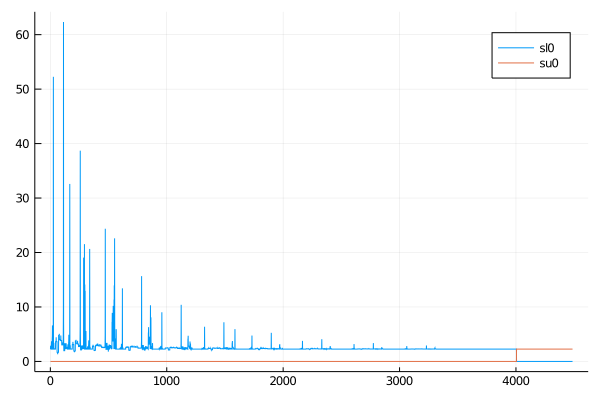

In [406]:
plot(stats_mpc4.multipliers_L, label="sl0")
plot!(stats_mpc4.multipliers_U, label="su0")

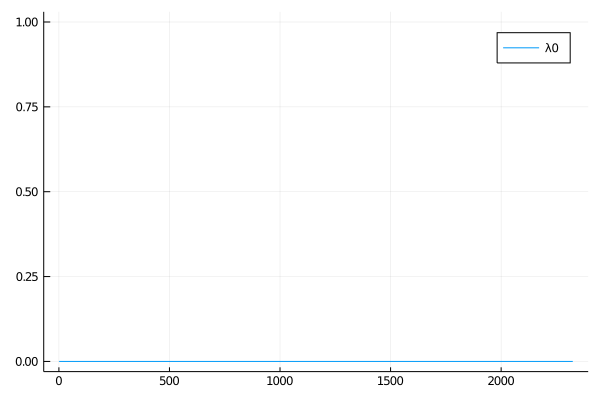

In [397]:
plot(stats_mpc4.multipliers, label="λ0")

# Tests sur tous les problèmes

In [752]:
# T = typeof(SM2.meta)
# for (name, typ) in zip(fieldnames(T), T.types)
#     println("type of the fieldname $name is $typ")
# end

In [25]:
problems = []
i_max = 11
i = 1
for file_name in readdir(path_pb)
    if file_name[end-3:end] == ".SIF" && !(file_name in ["80BAU3B.SIF" ; "BORE3D.SIF"; 
                                                        "CAPRI.SIF"; "CZPROB.SIF"; 
                                                        "ETAMACRO.SIF"; "FINNIS.SIF";
                                                        "FORPLAN.SIF"; "GREENBEA.SIF";
                                                        "GREENBEB.SIF"; "MAROS.SIF";
                                                        "NESM.SIF"; "PEROLD.SIF";
                                                         "PILOT-JA.SIF"; "PILOT-WE.SIF";
                                                         "PILOT.SIF"; "PILOT4.SIF";
                                                         "PILOT87.SIF"; "PILOTNOV.SIF";
                                                          "RECIPELP.SIF"; "SHELL.SIF";
                                                         "SIERRA.SIF"; "STAIR.SIF";
                                                         "STANDATA.SIF"; "STANDGUB.SIF";
                                                        "STANDMPS.SIF"; "TUFF.SIF";
                                                        "VTP-BASE.SIF"])   # problems with fixed variables


        println(file_name)
        pb_i = string(path_pb, "\\", file_name)
        if file_name in ["BLEND.SIF"; "DFL001.SIF"; "FORPLAN.SIF"; "GFRD-PNC.SIF"; "SIERRA.SIF"]
            qpdata_i = readqps(pb_i, mpsformat=:fixed) 
        else
            qpdata_i = readqps(pb_i) 
        end
        push!(problems, SlackModel(createQuadraticModel(qpdata_i, name=file_name[1:end-4])))
        
        if i==i_max
            break
        end
        i += 1
    end
end


25FV47.SIF
ADLITTLE.SIF
AFIRO.SIF


┌ Info: Using '25FV47' as NAME (l. 5)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'R0000' as objective (l. 21)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using '.00001' as RHS (l. 6793)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'ADLITTLE' as NAME (l. 5)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using '.Z....' as objective (l. 20)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'ZZZZ0001' as RHS (l. 333)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470


AGG.SIF
AGG2.SIF
AGG3.SIF
BANDM.SIF
BEACONFD.SIF


┌ Info: Using 'AFIRO' as NAME (l. 5)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'COST' as objective (l. 47)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'B' as RHS (l. 96)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'AGG' as NAME (l. 5)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJECTIV' as objective (l. 509)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'AGG' as RHS (l. 1852)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'AGG2' as NAME (l. 5)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJECTIV' as objective (l. 536)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\pa

BLEND.SIF


┌ Info: Using '11CSTR' as objective (l. 20)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'BEACON2' as RHS (l. 1996)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BLEND' as NAME (l. 5)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


BNL1.SIF
BNL2.SIF


┌ Info: Using 'C' as objective (l. 98)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using '' as RHS (l. 376)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BNL1' as NAME (l. 5)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ' as objective (l. 20)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 3994)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BNL2' as NAME (l. 5)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ' as objective (l. 20)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 11294)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSRea

In [61]:
problems_stats = solve_problems(mehrotraPCQuadBounds, problems, 
                                colstats=[:name, :status, :elapsed_time, :objective, :dual_feas, :primal_feas])

┌ Info:            Name           status      Time      f(x)      Dual    Primal  
└ @ SolverTools C:\Users\Geoffroy Leconte\.julia\packages\SolverTools\whyGk\src\bmark\run_solver.jl:67
┌ Info:    25FV47-slack       acceptable   8.0e-02   5.5e+03   2.6e-11   1.0e-10
└ @ SolverTools C:\Users\Geoffroy Leconte\.julia\packages\SolverTools\whyGk\src\bmark\run_solver.jl:83
┌ Info:  ADLITTLE-slack       acceptable   8.0e-03   2.3e+05   8.9e-11   3.8e-08
└ @ SolverTools C:\Users\Geoffroy Leconte\.julia\packages\SolverTools\whyGk\src\bmark\run_solver.jl:83
┌ Info:     AFIRO-slack       acceptable   0.0e+00  -4.6e+02   2.6e-09   8.1e-12
└ @ SolverTools C:\Users\Geoffroy Leconte\.julia\packages\SolverTools\whyGk\src\bmark\run_solver.jl:83
┌ Info:       AGG-slack       acceptable   2.4e-02  -3.6e+07   3.6e-10   5.1e-07
└ @ SolverTools C:\Users\Geoffroy Leconte\.julia\packages\SolverTools\whyGk\src\bmark\run_solver.jl:83
┌ Info:      AGG2-slack       acceptable   3.2e-02  -2.0e+07   2.1e-10   5.3e-

,id,name,nvar,ncon,nequ,status,objective,elapsed_time
,Int64,String,Int64,Int64,Int64,Symbol,Float64,Float64
1,1,25FV47-slack,1876,821,0,acceptable,5501.85,0.0799999
2,2,ADLITTLE-slack,138,56,0,acceptable,225495.0,0.00800014
3,3,AFIRO-slack,51,27,0,acceptable,-464.753,0.0
4,4,AGG-slack,615,488,0,acceptable,-3.59918e7,0.0239999
5,5,AGG2-slack,758,516,0,acceptable,-2.02393e7,0.0320001
6,6,AGG3-slack,758,516,0,acceptable,1.03121e7,0.0320001
7,7,BANDM,472,305,0,acceptable,-158.628,0.00800014
8,8,BEACONFD-slack,295,173,0,acceptable,33592.5,0.0079999
9,9,BLEND-slack,114,74,0,acceptable,-30.8121,0.0


In [19]:
markdown_table(stdout, problems_stats)

|    id |           name |  nvar |  ncon |  nequ |     status | objective | el ⋯
|-------|----------------|-------|-------|-------|------------|-----------|--- ⋯
|     1 |   25FV47-slack |  1876 |   821 |     0 | acceptable |   5.5e+03 |    ⋯
|     2 | ADLITTLE-slack |   138 |    56 |     0 | acceptable |   2.3e+05 |    ⋯
|     3 |    AFIRO-slack |    51 |    27 |     0 | acceptable |  -4.6e+02 |    ⋯
|     4 |      AGG-slack |   615 |   488 |     0 | acceptable |  -3.6e+07 |    ⋯
|     5 |     AGG2-slack |   758 |   516 |     0 | acceptable |  -2.0e+07 |    ⋯
|     6 |     AGG3-slack |   758 |   516 |     0 | acceptable |   1.0e+07 |    ⋯
|     7 |          BANDM |   472 |   305 |     0 | acceptable |  -1.6e+02 |    ⋯
|     8 | BEACONFD-slack |   295 |   173 |     0 | acceptable |   3.4e+04 |    ⋯
|     9 |    BLEND-slack |   114 |    74 |     0 | acceptable |  -3.1e+01 |    ⋯
|    10 |     BNL1-slack |  1586 |   643 |     0 | acceptable |   2.0e+03 |    ⋯
|    11 |     BNL2-slack |  

# Résultats sur tous les problèmes netlib

In [44]:
using JLD2

In [687]:
jldopen("mehrotra.jld2", "w") do file
    file["test"] = problems_stats
end


,id,name,nvar,ncon,nequ,status,objective,elapsed_time
,Int64,String,Int64,Int64,Int64,Symbol,Float64,Float64
1,1,25FV47-slack,1876,821,0,acceptable,5501.85,0.406
2,2,ADLITTLE-slack,138,56,0,acceptable,225495.0,0.00499988
3,3,AFIRO-slack,51,27,0,acceptable,-464.753,0.000999928
4,4,AGG-slack,615,488,0,acceptable,-3.59918e7,0.0180001
5,5,AGG2-slack,758,516,0,exception,Inf,Inf


In [22]:
using ProfileSVG

┌ Info: Precompiling ProfileSVG [132c30aa-f267-4189-9183-c8a63c7e05e6]
└ @ Base loading.jl:1260


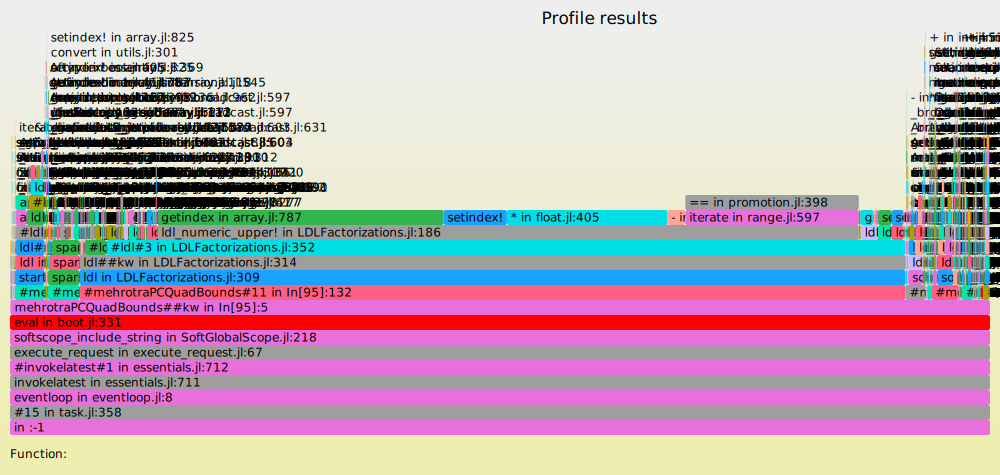

In [113]:
@profview mehrotraPCQuadBounds(SM4, display=false)